# Overview of work completed thus far:

- Data importing
    - Station information 
    - Total daily energy availability (to be predicted by ML model)
    - Weather variable predictions/forecasts
    
- Data wrangling
    - Ran a check for null values - none found
    - Ran a check for erroneous energy values (determined to be values not ending in 0) - these values makeup 0.42% of overall 
      values and will be removed
    - The goal is to create a list of observations (total daily energy availability) for each site on each day and
      combine with  the list of features 
    - This process was done using nested for loops - it feels somewhat sloppy to my and I am open to feedback on improving
      the process
    - Currently uses only 5 of 98 stations to reduce computation time for testing - I have ran it once with all stations and
      got similar results in the regression
        - For each station:
        - For each weather prediction/forecast variable:
            - Merge the list of energy data for a specific station with the list of stations
            - Get all weather variable forecasts for all days, forecast hours, gridpoints, 11 predictive models
            - Use only the weather variable forecasts from the latitude and longitude of the closest gridpoint to the station
            - Take the median value of the 11 different predictive models
            - Pivot the forecast hour to be a 5 different columns for each of the 5 forecast hours
            - Merge the weather variable predictions/forecasts for each day with the total energy availability
    - There is some data cleaning still to be completed
    
- Exploratory data analysis
    - Not yet completed
    
- Machine learning regression
    - ML regression model implemented mostly to make sure my data was in the correct structure and that the features made sense
    - Will be developed further as I complete the machine learning module
    - Currently predicting total daily energy availability with an average of ~13-14% accuracy

# Modules Import

In [1]:
# Import necessary modules

import numpy as np
import netCDF4 as nc
import pandas as pd

import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import glob
from functools import reduce

from mpl_toolkits.basemap import Basemap, cm
import seaborn as seabornInstance 

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

C:\Users\conno\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\conno\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Data Import

In [3]:
# Import the station location data and station energy data

# Station data is the list of 98 Mesonet solar farm IDs, their location (longitude, latitude, elevation)
stations = pd.read_csv('station_info.csv')

# Energy data is the total daily energy availability on each day for each station
energy = pd.read_csv('train.csv', parse_dates=True, index_col='Date')

print(stations.head())
print(energy.head())

   stid      nlat      elon  elev
0  ACME  34.80833 -98.02325   397
1  ADAX  34.79851 -96.66909   295
2  ALTU  34.58722 -99.33808   416
3  APAC  34.91418 -98.29216   440
4  ARNE  36.07204 -99.90308   719
                ACME      ADAX      ALTU      APAC      ARNE      BEAV  \
Date                                                                     
1994-01-01  12384900  11930700  12116700  12301200  10706100  10116900   
1994-01-02  11908500   9778500  10862700  11666400   8062500   9262800   
1994-01-03  12470700   9771900  12627300  12782700  11618400  10789800   
1994-01-04  12725400   6466800  13065300  12817500  12134400  11816700   
1994-01-05  10894800  11545200   8060400  10379400   6918600   9936300   

                BESS      BIXB      BLAC      BOIS  ...      VINI      WASH  \
Date                                                ...                       
1994-01-01  11487900  11182800  10848300  10225200  ...  10771800  12116400   
1994-01-02   9235200   3963300   3318300

In [4]:
# Import the weather variable forecasts
# Forecasts are separated into 15 different files for each forecast variable (e.g. air pressure, specific humidity, etc.)
# Each variable is forecast using 11 different predictive models at 144 gridpoint locations
# (on 16 lines of longitude and 9 lines of latitude)

# Take any filename that ends in .nc and add to a list of the files
weather_file_list = glob.glob('*.nc')

# Take the data from each file in the file list and put into a list of data
list_of_data = [xr.open_dataset(filename) for filename in weather_file_list]

# Convert list of data to a list of dataframes
# Each dataframe consists of forecast data for a single weather variable
list_of_dfs = [data_file.to_dataframe() for data_file in list_of_data]

list_of_dfs[0].head()

intTime  intValidTime  \
ens fhour    lat  lon   time                                   
0   12:00:00 31.0 254.0 1994-01-01  1994010100    1994010112   
                        1994-01-02  1994010200    1994010212   
                        1994-01-03  1994010300    1994010312   
                        1994-01-04  1994010400    1994010412   
                        1994-01-05  1994010500    1994010512   

                                    Total_precipitation  
ens fhour    lat  lon   time                             
0   12:00:00 31.0 254.0 1994-01-01                  0.0  
                        1994-01-02                  0.0  
                        1994-01-03                  0.0  
                        1994-01-04                  0.0  
                        1994-01-05                  0.0

# Data Wrangling

In [20]:
# Check for null values in energy data
energy.isnull().any().any()

False

In [21]:
# Check for null values in weather variable data
null_check = []

for df in list_of_dfs:
    null_check.append(df.isnull().any().any())

print(null_check)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [6]:
# Check for repeating values as client has stated that pyranometers occasionally do not function correctly
# Repeating values appear to end in a number that is not 0
energy.ACME.value_counts().head()

11010048    13
13517100     4
18781200     3
25608600     2
29627400     2
Name: ACME, dtype: int64

In [7]:
energy.ADAX.value_counts().head()

10223616    14
11530800     3
23339400     3
13851600     3
17067300     2
Name: ADAX, dtype: int64

In [8]:
energy.CLAY.value_counts().head()

12320768    104
15594000      3
12843900      3
12471900      3
7706400       2
Name: CLAY, dtype: int64

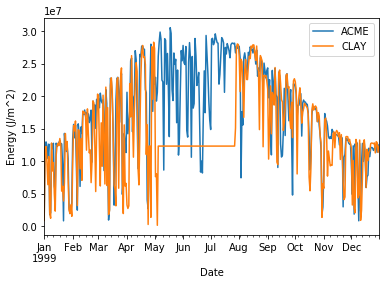

In [10]:
energy.ACME.loc['1999'].plot()
energy.CLAY.loc['1999'].plot()
plt.ylabel('Energy (J/m^2)')
plt.legend()
# Continuous energy value given for CLAY May-July - erroneous

In [10]:
columns = list(energy)
error_val_count = {}

for column in columns:
    for row in range(energy[column].size):
        if str(energy[column][row])[-1] != '0':
            if not column in error_val_count:
                error_val_count[column] = 1
            else:
                error_val_count[column] += 1

In [11]:
error_val_count

{'ACME': 13,
 'ADAX': 14,
 'BEAV': 9,
 'BESS': 25,
 'BIXB': 51,
 'BOWL': 12,
 'BREC': 1,
 'BRIS': 18,
 'BUFF': 19,
 'BURB': 60,
 'BURN': 32,
 'BYAR': 26,
 'CHER': 4,
 'CHEY': 38,
 'CHIC': 22,
 'CLAY': 104,
 'COOK': 5,
 'COPA': 2,
 'ELRE': 6,
 'ERIC': 79,
 'EUFA': 48,
 'FAIR': 301,
 'FORA': 14,
 'FREE': 1,
 'FTCB': 8,
 'GOOD': 92,
 'GUTH': 1,
 'HASK': 63,
 'HOBA': 1,
 'HOLL': 1,
 'HUGO': 10,
 'IDAB': 21,
 'KENT': 3,
 'MADI': 10,
 'MARE': 1,
 'MAYR': 33,
 'MEDI': 26,
 'MIAM': 4,
 'MTHE': 219,
 'NINN': 57,
 'OKEM': 52,
 'OKMU': 69,
 'PRYO': 14,
 'REDR': 5,
 'RETR': 45,
 'RING': 6,
 'SALL': 50,
 'SHAW': 3,
 'SKIA': 1,
 'SLAP': 118,
 'SPEN': 43,
 'STIG': 9,
 'STUA': 2,
 'TALI': 12,
 'TIPT': 1,
 'VINI': 16,
 'WATO': 11,
 'WEST': 149,
 'WILB': 34,
 'WIST': 14,
 'WYNO': 14}

In [12]:
total_errors = sum(error_val_count.values())
total_values = energy.shape[0] * energy.shape[1]
error_value_pct = total_errors / total_values * 100
print('Total Erroneous Values: ' + str(total_errors))
print('Total Values: ' + str(total_values))
print('Percent of Total Values being Erroneous: ' + str(error_value_pct)[0:4] + '%')

Total Erroneous Values: 2122
Total Values: 501074
Percent of Total Values being Erroneous: 0.42%


In [46]:
# Add filename column to each row of each dataframe
for dataframe, filename in zip(list_of_dfs, weather_file_list):
    dataframe['filename'] = filename

In [14]:
# Create a dataframe with all the stations and their energy
# Data has been transformed from having stations as column labels to a list of stations and
# their total daily energy availability
energy_melt = pd.melt(energy.reset_index(), id_vars='Date', var_name='stid', value_name='energy').set_index('Date')

In [15]:
# Create function to find the closest weather prediction/forecast gridpoint for a Mesonet Station
def closest_gridpoint(station_id):
    '''
Calculates the closest longitude and latitute gridpoint for an input station ID
    '''
    # Set station latitude and longitude
    # Longitude adjusted by 360 deg. to be at same datum as weather prediction gridpoints
    st_lat = stations[stations.stid == station_id]['nlat'].iloc[0]
    st_lon = stations[stations.stid == station_id]['elon'].iloc[0] + 360
    
    # Create lists of gridpoint latitudes and longitudes
    lats = list(range(31,40))
    lons = list(range(254,270))
    
    # Calculate the difference between the station lon/lat and each gridpoint lon/lat
    lat_dif = list(abs(lats - st_lat))
    lon_dif = list(abs(lons - st_lon))
    
    # Calculate the gridpoint coordinates as the lon/lat with the minimum difference calculated above
    gridpoint_coords = [lats[lat_dif.index(min(lat_dif))], lons[lon_dif.index(min(lon_dif))]]
    
    return gridpoint_coords

In [49]:
# The features for the ML model must be calculated and organized

# For each df in list_of_df, extract the weather variable column
# Take the median value of the ensemble variables by grouping
# Use the closest gridpoint (for now) for forecast values
# Use the 5 timestamps as 5 different features

# Create a short list of stations for testing
stations_short = stations.head()

# Run through each station
for j, station in enumerate(stations_short.stid):
    
    # Merge the list of energy data for a specific station with the list of stations
    energy_melt_temp = pd.merge(energy_melt[energy_melt.stid == station].reset_index(), stations_short, how='inner', on='stid')
    energy_melt_temp['elon'] = energy_melt_temp['elon'] + 360 

    # Use the closest gridpoint function to get the gridpoints to be used to determine which weather forecast data will be 
    # used as features for each station
    gridpoint_coords = closest_gridpoint(station)
    
    # Run through each weather forecast variable
    for i, df in enumerate(list_of_dfs):
    
        # Get the variable name and shorten it
        w_variable_name = df.iloc[0,-1]
        w_variable_name = w_variable_name[0:9]

        # Get all weather variable forecasts for all days, forecast hours, gridpoints, 11 predictive models
        weather_vars = pd.DataFrame(df.iloc[:, 2])
        weather_vars = weather_vars.reset_index().set_index('time')

        # Use only the weather variable forecasts from the latitude and longitude of the closest gridpoint to the station
        # May be adjusted in the future to take the median of the closest 5 gridpoints, etc.
        weather_vars = weather_vars[weather_vars.lat == gridpoint_coords[0]]
        weather_vars = weather_vars[weather_vars.lon == gridpoint_coords[1]]

        # Take the median value of the 11 different predictive models
        weather_vars = weather_vars.reset_index()
        weather_vars = weather_vars.groupby(by=['time','fhour', 'lat', 'lon']).median()
        del weather_vars['ens']
        
        # Pivot the forecast hour to be a 5 different columns for each of the 5 forecast hours
        weather_vars = weather_vars.reset_index().set_index('time')
        weather_vars = weather_vars.pivot(columns='fhour', values=weather_vars.columns[-1])

        # Set the column names of the forecast variables / forecast hours
        weather_column_list = [w_variable_name + 'fhour0', w_variable_name + 'fhour1', w_variable_name + 'fhour2', w_variable_name + 'fhour3', w_variable_name + 'fhour4']
        weather_vars.columns = weather_column_list
    
        # For the first iteration, create the complete weather variable dataframe, else add on to the existing dataframe
        if i == 0:
            energy_melt_complete = pd.merge(energy_melt_temp.reset_index(), weather_vars.reset_index(), how='outer', left_on='Date', right_on='time')
            del energy_melt_complete['time']
        else:
            energy_melt_complete = pd.merge(energy_melt_complete.reset_index(drop=True), weather_vars.reset_index(), how='outer', left_on='Date', right_on='time')
            del energy_melt_complete['time']
            
    # For the first iteration, create the complete dataframe, else add on to the existing dataframe        
    if j == 0:
        dataset = energy_melt_complete
    else:
        dataset = dataset.append(energy_melt_complete)

In [50]:
# Export dataset to csv for safekeeping
export_csv = dataset.to_csv (r'ML_dataset_short.csv', index = None, header=True) 

In [51]:
# The format of this dataset is as follows:
# Each row is an observation of total daily energy availablity at a given station for a given day
# There are 81 features:
    # Latitude, longitude, elevation (3)
    # 15 weather forecast variables at 5 timestamps (75)
    # Year, month, day (3)

# Aspects of the dataset that may change:
    # The 11 prediction/forecast models have been reduced to a single weather forecast value by taking the median
    # The prediction/forecast data is taken from the closest forecast gridpoint to the station
    # As noted above, the 5 timestamps are used as seperate features

del dataset['index']
dataset

,Date,stid,energy,nlat,elon,elev,apcp_sfc_fhour0,apcp_sfc_fhour1,apcp_sfc_fhour2,apcp_sfc_fhour3,...,ulwrf_tatfhour0,ulwrf_tatfhour1,ulwrf_tatfhour2,ulwrf_tatfhour3,ulwrf_tatfhour4,uswrf_sfcfhour0,uswrf_sfcfhour1,uswrf_sfcfhour2,uswrf_sfcfhour3,uswrf_sfcfhour4
0,1994-01-01,ACME,12384900,34.80833,261.97675,397,0.00,0.00,0.00,0.00,...,244.599884,250.697769,253.000000,263.599396,260.805176,0.0,9.0,49.0,107.0,74.0
1,1994-01-02,ACME,11908500,34.80833,261.97675,397,0.00,0.00,0.00,0.01,...,229.677521,232.064819,232.535034,231.007874,232.050873,0.0,8.0,35.0,73.0,49.0
2,1994-01-03,ACME,12470700,34.80833,261.97675,397,0.00,0.00,0.00,0.00,...,239.216248,232.011292,235.497711,252.005936,247.466858,0.0,9.0,50.0,111.0,75.0
3,1994-01-04,ACME,12725400,34.80833,261.97675,397,0.00,0.00,0.00,0.00,...,231.955521,243.538940,245.449066,254.235535,250.001099,0.0,9.0,50.0,112.0,77.0
4,1994-01-05,ACME,10894800,34.80833,261.97675,397,0.00,0.00,0.00,0.00,...,235.535767,235.320099,242.186722,258.269745,241.109451,0.0,8.0,48.0,107.0,71.0
5,1994-01-06,ACME,6639000,34.80833,261.97675,397,0.00,0.00,0.00,0.00,...,265.162933,257.046600,256.037262,257.222290,253.300598,0.0,8.0,49.0,108.0,74.0
6,1994-01-07,ACME,13244700,34.80833,261.97675,397,0.00,0.00,0.00,0.00,...,202.000000,221.694839,225.213394,247.000000,244.475220,0.0,9.0,52.0,118.0,82.0
7,1994-01-08,ACME,12927900,34.80833,261.97675,397,0.00,0.00,0.00,0.00,...,223.074158,220.711426,227.366760,249.627869,248.322418,0.0,9.0,50.0,112.0,79.0
8,1994-01-09,ACME,12600300,34.80833,261.97675,397,0.00,0.00,0.00,0.00,...,225.648453,221.541687,221.808289,218.271622,222.005951,0.0,7.0,47.0,103.0,71.0
9,1994-01-10,ACME,6406500,34.80833,261.97675,397,0.83,0.23,0.46,0.02,...,242.360062,242.049957,234.099884,240.100067,249.133240,0.0,3.0,15.0,63.0,52.0


# Exploratory Data Analysis

In [52]:
EDA_data = pd.read_csv('ML_dataset.csv')

In [53]:
energy_sum = EDA_data.groupby(by='stid').sum()['energy']
energy_sum = pd.merge(energy_sum, stations, on='stid')

In [54]:
def basic_oklahoma_map(ax=None, lllat=34, urlat=42,
                   lllon=-45, urlon=-75):
    '''
    Function for creating basemap object: https://github.com/joelmpiper/solar_energy_prediction/blob/master/notebooks/slides/FinalPresentation.ipynb
    '''
    m = Basemap(ax=ax, projection='stere', lon_0=(urlon + lllon)/2,
               lat_0=(urlat + lllat) / 2, llcrnrlat = lllat, urcrnrlat=urlat,
               llcrnrlon=lllon, urcrnrlon=urlon,
               resolution='f')
    m.drawstates()
    return m

In [69]:
data = energy_sum['energy'].values/1000000000

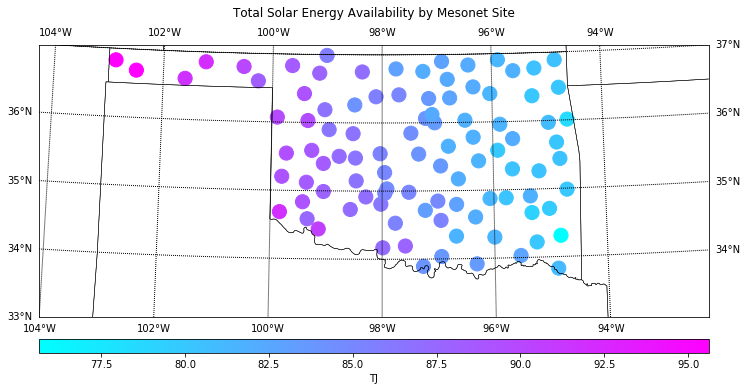

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

lllat=33; urlat=37; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10)
# draw meridians
meridians = np.arange(-104.,-92.,2.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10)

data = energy_sum['energy'].values/1000000000
lons = energy_sum['elon']
lats = energy_sum['nlat']
x, y = m(lons.values, lats.values)

cs = m.scatter(x,y, s=200, c=data, cmap='cool')
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label('TJ/m^2')
# add title
plt.title("Total Solar Energy Availability by Mesonet Site", y=1.08)
plt.show()

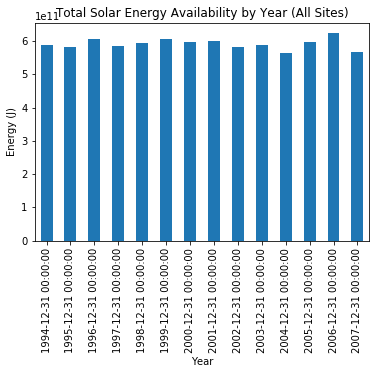

In [57]:
total_energy = energy.resample('A').sum().sum(axis=1)
total_energy.plot.bar()
plt.title("Total Solar Energy Availability by Year (All Sites)")
plt.xlabel('Year')
#plt.xticks(total_energy.index, rotation=45)
plt.ylabel('Energy (J/m^2)')
plt.show()

# Conclusions from EDA

- 
- 

# Implement ML regression

In [3]:
ML_dataset = pd.read_csv("ML_dataset.csv") 

In [4]:
# Set features and targets
ML_dataset['year'] = ML_dataset.Date.apply(lambda x: x[0:4])
ML_dataset['month'] = ML_dataset.Date.apply(lambda x: x[5:7])
ML_dataset['day'] = ML_dataset.Date.apply(lambda x: x[8:10])

X = ML_dataset.iloc[:, 4:].values
y = ML_dataset.iloc[:, 3].values

In [5]:
ML_dataset.head()

,index,Date,stid,energy,nlat,elon,elev,apcp_sfc_fhour0,apcp_sfc_fhour1,apcp_sfc_fhour2,...,ulwrf_tatfhour3,ulwrf_tatfhour4,uswrf_sfcfhour0,uswrf_sfcfhour1,uswrf_sfcfhour2,uswrf_sfcfhour3,uswrf_sfcfhour4,year,month,day
0,0,1994-01-01,ACME,12384900,34.80833,261.97675,397,0.0,0.0,0.0,...,263.59940,260.80518,0.0,9.0,49.0,107.0,74.0,1994,01,01
1,1,1994-01-02,ACME,11908500,34.80833,261.97675,397,0.0,0.0,0.0,...,231.00787,232.05087,0.0,8.0,35.0,73.0,49.0,1994,01,02
2,2,1994-01-03,ACME,12470700,34.80833,261.97675,397,0.0,0.0,0.0,...,252.00594,247.46686,0.0,9.0,50.0,111.0,75.0,1994,01,03
3,3,1994-01-04,ACME,12725400,34.80833,261.97675,397,0.0,0.0,0.0,...,254.23553,250.00110,0.0,9.0,50.0,112.0,77.0,1994,01,04
4,4,1994-01-05,ACME,10894800,34.80833,261.97675,397,0.0,0.0,0.0,...,258.26974,241.10945,0.0,8.0,48.0,107.0,71.0,1994,01,05


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [7]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [8]:
y_pred = regressor.predict(X_test)

In [9]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

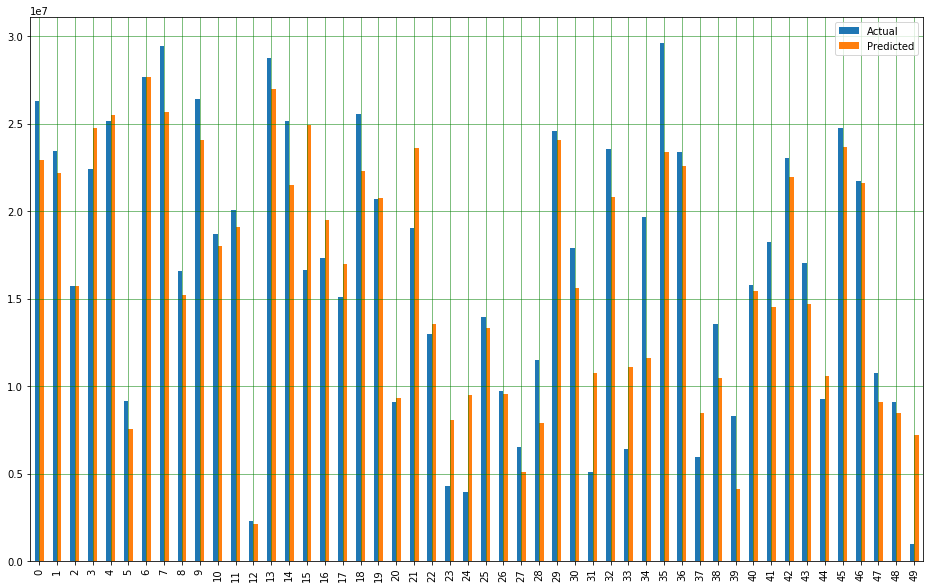

In [10]:
df1 = df.head(50)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [11]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2348221.406035201
Mean Squared Error: 11043009026148.807
Root Mean Squared Error: 3323102.3195425095


In [13]:
# MAE as a percentage of the mean target
error_pct = metrics.mean_absolute_error(y_test, y_pred) / ML_dataset.energy.mean() * 100
error_pct

14.209171913021395